# Data Setup

In [144]:
import random
import numpy as np

import cudf
from cudf.datasets import randomdata

def valid_str():
    return np.random.choice(['infinity', '-infinity', '+infinity', 'inf', '-inf', '+inf'])

def make_data(height):
    width_factor = 2
    valid_frac = 0.5

    strcol = randomdata(nrows=int(height * (1.0 - valid_frac)), dtypes={'a': str})['a']._column
    for _ in range(1, width_factor):
        strcol = strcol.str().cat(others=strcol)
    
    valid_l = [valid_str() for _ in range(int(valid_frac * height))]
    strcol = strcol.append(valid_l)
    
    # shuffle
    idx = np.array(range(len(strcol)))
    randidx = idx.copy()
    np.random.shuffle(randidx)
    strcol[idx] = strcol[randidx]
    
    return cudf.Series(strcol)

In [145]:
def regex_replace(s):
    col = s._column
    col = col.str().replace("\\+?(inf|infinity)$", "Inf", regex=True)
    col = col.str().replace("-(inf|infinity)$", "-Inf", regex=True)
    
def literal_replace(s):
    col = s._column
    col = col.str().replace("+infinity", "Inf", regex=False)
    col = col.str().replace("-infinity", "-Inf", regex=False)
    col = col.str().replace("infinity", "Inf", regex=False)
    col = col.str().replace("+inf", "Inf", regex=False)
    col = col.str().replace("-inf", "-Inf", regex=False)
    col = col.str().replace("inf", "Inf", regex=False)

def literal_replace_v2(s):
    col = s._column
    col = col.str().replace(["+infinity","-infinity","infinity","+inf","-inf","inf"],["Inf","-Inf","Inf","Inf","-Inf","Inf"], regex=False)
    
def scatter_replace(s):
    s[(s == 'inf') | (s == '+inf') | (s == 'infinity') | (s == '+infinity')] = 'Inf'
    s[(s == '-inf') | (s == '-infinity')] = '-Inf'

def where_replace(s):
    s.where((s == 'inf') | (s == '+inf') | (s == 'infinity') | (s == '+infinity'), 'Inf')
    s.where((s == '-inf') | (s == '-infinity'), '-Inf')

In [146]:
import timeit

def run_and_time(repeats, f, *args):
    start = timeit.default_timer()
    for _ in range(repeats):
        f(*args)
    end = timeit.default_timer()
    return (end - start) / repeats

# Experiment

In [147]:
import pandas as pd

methods = ['regex', 'literal', 'literalv2', 'scat', 'where']
heights = [1000, 10000, 100000, 1000000, 10000000]

index = pd.Index(methods)
df = pd.DataFrame(index=index)

repeats = 100
for h in heights:
    s = make_data(h)
    
    regex_time = run_and_time(repeats, regex_replace, s)
    literal_time = run_and_time(repeats, literal_replace, s)
    literalv2_time = run_and_time(repeats, literal_replace_v2, s)
    scat_time = run_and_time(repeats, scatter_replace, s)
    where_time = run_and_time(repeats, where_replace, s)

    df[h] = [regex_time, literal_time, literalv2_time, scat_time, where_time]
    

/home/wangm/dev/rapids/cudf/python/cudf/cudf/core/column/string.py:703: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  "`n` parameter is not supported when "


In [148]:
df

,1000,10000,100000,1000000,10000000
regex,0.001516,0.001518,0.003258,0.018097,0.159826
literal,0.003125,0.003089,0.002949,0.007396,0.030389
literalv2,0.000951,0.000953,0.000887,0.001963,0.009677
scat,0.010069,0.009815,0.011083,0.017761,0.044090
where,0.008498,0.008494,0.008576,0.015705,0.036888


In [149]:
%matplotlib inline

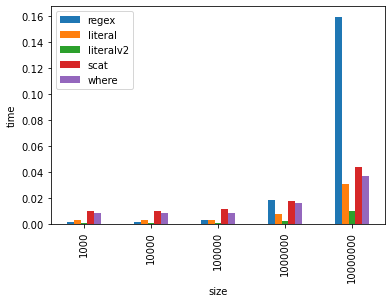

In [150]:
ax = df.T.plot.bar(xlabel='size', ylabel='time')